## Data Preprocessing

### Data Cleaning
- remove `Source`, `Description`
  - Column does not align with the intended analysis plan or contribute significantly to the objectives of the study.
- remove all rows in `2023`
  - at the a time of writing this code (2024-01-05T06:48:57.747Z),the dataset is not complete for year 2023, only first 3 months included


### Split data into smaller groups
The split has been performed according to the following categories:

#### Traffic Impact:
Columns: Severity, Distance(mi)

#### Time:
Columns: Start_Time, End_Time, Timezone

#### Coordinates:
Columns: Start_Lat, Start_Lng, End_Lat, End_Lng

#### Address:
Columns: Street, City, County, State, Zipcode

#### Weather:
Columns: Airport_Code, Weather_Timestamp, Temperature(F), Wind_Chill(F), Humidity(%), Pressure(in), Visibility(mi), Wind_Direction, Wind_Speed(mph), Precipitation(in), Weather_Condition

#### Points of Interest (POI):
Columns: Amenity, Bump, Crossing, Give_Way, Junction, No_Exit, Railway, Roundabout, Station, Stop, Traffic_Calming, Traffic_Signal, Turning_Loop

#### Daylight:
Columns: Sunrise_Sunset, Civil_Twilight, Nautical_Twilight, Astronomical_Twilight

In [1]:
columns_names_map = {
    'traffic_impact'  : ['Severity', 'Distance(mi)'],
    'time'            : ['Start_Time', 'End_Time', 'Timezone'],
    'coordinates'     : ['Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng'],
    'address'         : ['Street', 'City', 'County', 'State', 'Zipcode'],
    'weather'         : ['Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition'],
    'poi'             : ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop'],
    'daylight'        : ['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'],
}

header = ['ID']
for value in columns_names_map.values():
    header += value

### Convert measurements unit
By doing this conversion, we also:
    - round up to 1 decimal digit
    - remove the original columns
#### Convert
along with convert measurements unit, we also change the column names, as show in the `convert_columns_map`
- Convert miles to meters
- Convert miles/h to km/h
- Convert Fahrenheit degrees to Celsius degrees
- Convert inches to centimeters

In [2]:
convert_columns_map = {
    'Distance(mi)'      : 'Distance(m)',
    'Temperature(F)'    : 'Temperature(C)',
    'Wind_Chill(F)'     : 'Wind_Chill(C)',
    'Visibility(mi)'    : 'Visibility(m)',
    'Precipitation(in)' : 'Precipitation(cm)',
    'Wind_Speed(mph)'   : 'Wind_Speed(kmh)',
}
convert_columns = convert_columns_map.keys()

In [3]:
import pandas as pd
import os
import warnings
from utils import convert

warnings.filterwarnings("error")

source_path = './data/raw/sample.csv'

sample = pd.read_csv(source_path, usecols=header)
sample

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Street,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2047758,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,Highway 19,...,False,False,False,False,True,False,Day,Day,Day,Day
1,A-4694324,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,38.990037,-77.398282,0.056,Forest Ridge Dr,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-5006183,2,2022-08-20 13:13:00.000000000,2022-08-20 15:22:45.000000000,34.661189,-120.492822,34.661189,-120.492442,0.022,Floradale Ave,...,False,False,False,False,True,False,Day,Day,Day,Day
3,A-4237356,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,14th St NW,...,False,False,False,False,False,False,Day,Day,Day,Day
4,A-6690583,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,River Blvd,...,False,False,False,False,False,False,Night,Night,Night,Night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,A-6077227,2,2021-12-15 07:30:00,2021-12-15 07:50:30,45.522510,-123.084104,45.520225,-123.084211,0.158,Quince St,...,False,False,False,False,False,False,Night,Day,Day,Day
499996,A-6323243,2,2021-12-19 16:25:00,2021-12-19 17:40:37,26.702570,-80.111169,26.703141,-80.111133,0.040,N Military Trl,...,False,False,False,False,False,False,Day,Day,Day,Day
499997,A-3789256,2,2022-04-13 19:28:29,2022-04-13 21:33:44,34.561862,-112.259620,34.566822,-112.267150,0.549,E AZ-69,...,False,False,False,False,True,False,Night,Night,Day,Day
499998,A-7030381,3,2020-05-15 17:20:56,2020-05-15 17:50:56,38.406680,-78.619310,38.406680,-78.619310,0.000,W Spotswood Trl,...,False,False,False,False,True,False,Day,Day,Day,Day


#### Percentage of data missing

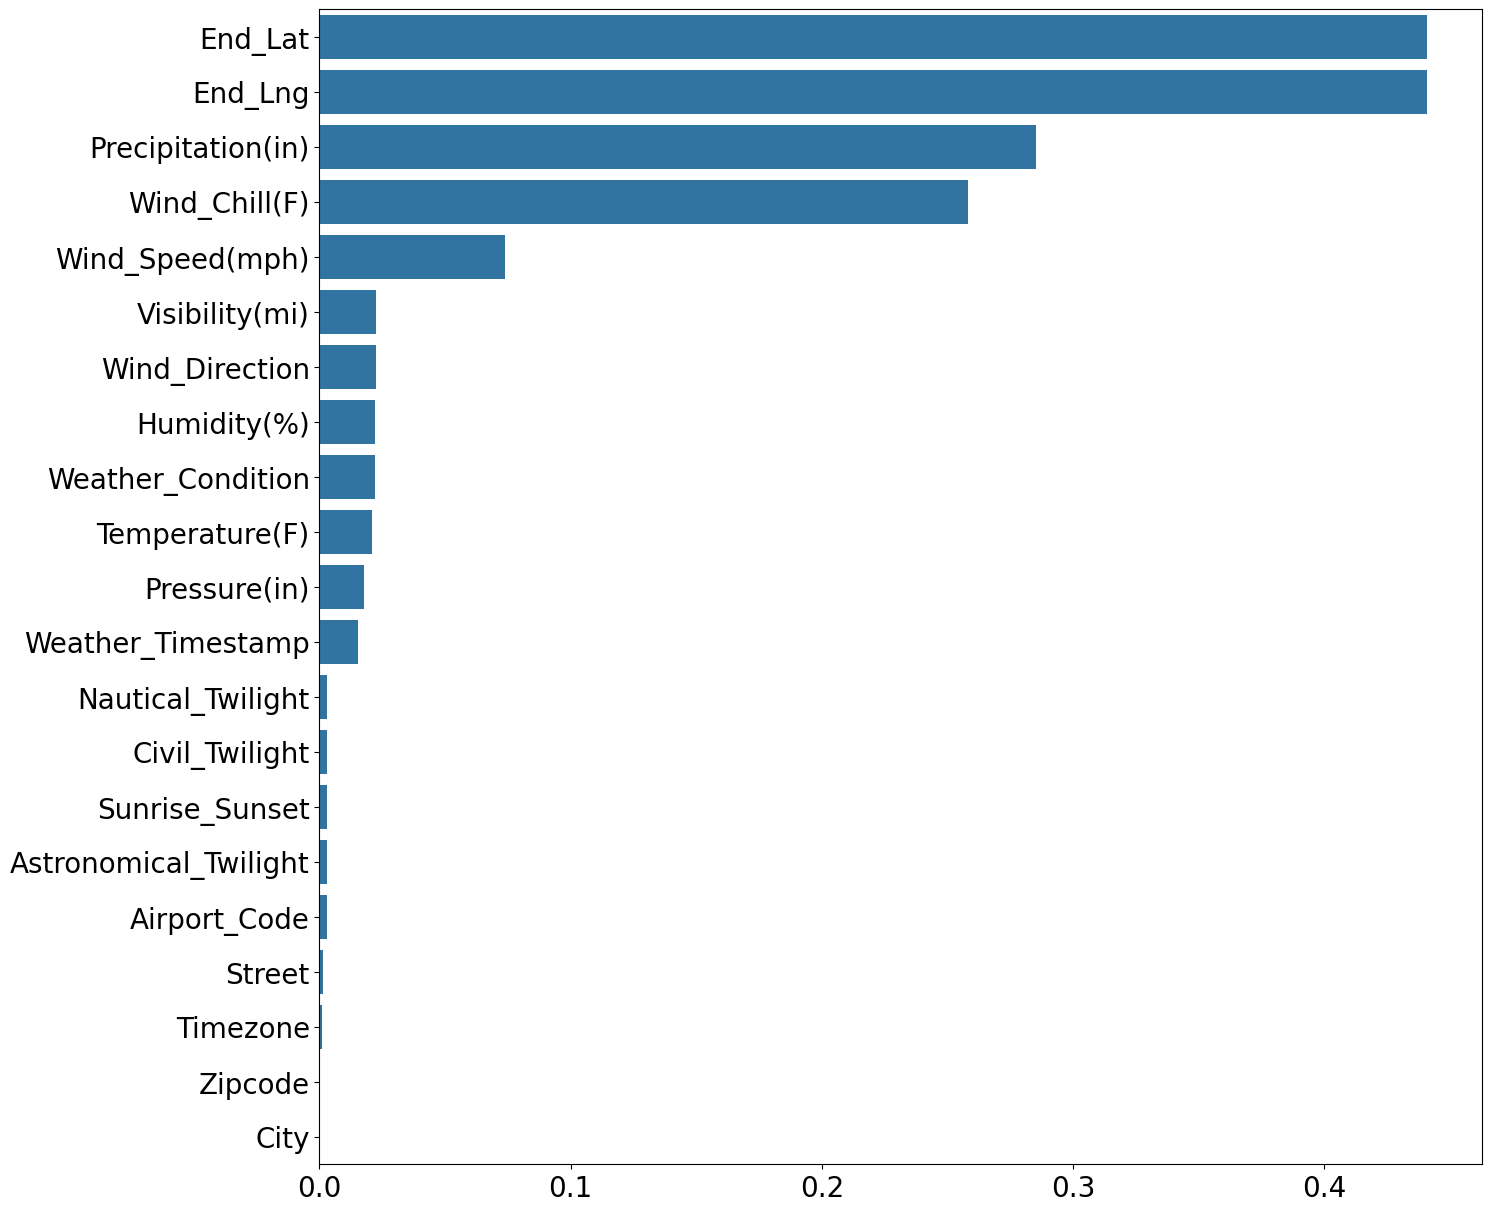

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

df_na_percentage = sample.isna().sum().sort_values(ascending=False) / len(sample)
df_na_percentage

plt.figure(figsize=(15,15))

sns.barplot(df_na_percentage[df_na_percentage != 0], orient='h')

plt.xticks(fontsize=20)  # Adjust the font size as needed
plt.yticks(fontsize=20)  # Adjust the font size as needed
plt.show()

#### Drop 2023 data

In [5]:
rows_in_2023 = sample[sample['Start_Time'].str.contains('2023')]
sample.drop(rows_in_2023.index, inplace=True)

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Street,...,weekday_name,weekend,month,day,Distance(m),Temperature(C),Wind_Chill(C),Visibility(m),Precipitation(cm),Wind_Speed(kmh)
0,A-2047758,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,Highway 19,...,Wed,0,6,12,0.0,25.0,25.0,-12.2,0.0,8.0
1,A-4694324,2,2022-12-03 23:37:14,2022-12-04 01:56:53,38.990562,-77.399070,38.990037,-77.398282,0.056,Forest Ridge Dr,...,Sat,1,12,3,90.1,7.2,6.1,-12.2,0.0,8.0
2,A-5006183,2,2022-08-20 13:13:00,2022-08-20 15:22:45,34.661189,-120.492822,34.661189,-120.492442,0.022,Floradale Ave,...,Sat,1,8,20,35.4,20.0,20.0,-12.2,0.0,20.9
3,A-4237356,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,14th St NW,...,Mon,0,2,21,1696.2,-2.8,-9.4,-12.2,0.0,24.1
4,A-6690583,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,River Blvd,...,Fri,0,12,4,74.0,5.6,5.6,-12.2,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,A-6077227,2,2021-12-15 07:30:00,2021-12-15 07:50:30,45.522510,-123.084104,45.520225,-123.084211,0.158,Quince St,...,Wed,0,12,15,254.3,4.4,0.0,-12.2,0.0,24.1
499996,A-6323243,2,2021-12-19 16:25:00,2021-12-19 17:40:37,26.702570,-80.111169,26.703141,-80.111133,0.040,N Military Trl,...,Sun,1,12,19,64.4,25.6,25.6,-12.2,0.0,20.9
499997,A-3789256,2,2022-04-13 19:28:29,2022-04-13 21:33:44,34.561862,-112.259620,34.566822,-112.267150,0.549,E AZ-69,...,Wed,0,4,13,883.5,11.1,11.1,-12.2,0.0,19.3
499998,A-7030381,3,2020-05-15 17:20:56,2020-05-15 17:50:56,38.406680,-78.619310,38.406680,-78.619310,0.000,W Spotswood Trl,...,Fri,0,5,15,0.0,27.8,27.8,-12.2,0.0,22.5


#### Process datatime columns

In [ ]:
# replace 2022-12-03 23:37:14.00000000 -> 2022-12-03 23:37:14
sample['Start_Time'] = sample['Start_Time'].str.replace(r'\.\d{3,}', '', regex=True)
sample['Start_Time'] = pd.to_datetime(sample['Start_Time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

sample['End_Time']   = sample['End_Time'].str.replace(r'\.\d{3,}', '', regex=True)
sample['End_Time']   = pd.to_datetime(sample['End_Time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

sample['year']           = sample['Start_Time'].dt.strftime("%Y").astype(int)
sample['hour']           = sample['Start_Time'].dt.hour
sample['weekday']        = sample['Start_Time'].dt.weekday.astype(int)
sample['weekday_name']   = sample['weekday'].apply(convert.weekday_index_to_name)
sample['weekend']        = sample['weekday'].apply(lambda x: 1 if x in [5, 6] else 0)
sample['month']          = sample['Start_Time'].dt.month
sample['day']            = sample['Start_Time'].dt.day

new_datetime_column = [ 'year', 'hour', 'weekday', 'weekday_name', 'weekend', 'month', 'day' ]
columns_names_map['time'] += new_datetime_column
columns_names_map['time']

#### Convert unit measurements columns

In [ ]:
sample['Distance(m)']            = sample['Distance(mi)'].apply(convert.miles_to_meters).round(1)
sample.drop('Distance(mi)', axis=1)

sample['Temperature(C)']         = sample['Temperature(F)'].apply(convert.fahrenheit_to_celsius).round(1)
sample.drop('Temperature(F)', axis=1)

sample['Wind_Chill(C)']          = sample['Wind_Chill(F)'].apply(convert.fahrenheit_to_celsius).round(1)
sample.drop('Wind_Chill(F)', axis=1)

sample['Visibility(m)']          = sample['Visibility(mi)'].apply(convert.fahrenheit_to_celsius).round(1)
sample.drop('Visibility(mi)', axis=1)

sample['Precipitation(cm)']      = sample['Precipitation(in)'].apply(convert.inches_to_centimeters).round(1)
# sample.drop('Precipitation(in)', axis=1)

sample['Wind_Speed(kmh)']        = sample['Wind_Speed(mph)'].apply(convert.mph_to_kmh).round(1)
sample.drop('Wind_Speed(mph)', axis=1)

In [7]:
# at the a time of writing this code (2024-01-05T06:48:57.747Z),
# the dataset is not complete for year 2023,
# only first 3 months included


for key in columns_names_map.keys():
    columns = columns_names_map[key]

    for (index, value) in enumerate(columns):
        if value in convert_columns:
            columns[index] = convert_columns_map[value]

    all_columns = ['ID'] + columns
    df = sample[all_columns]
    file_path = f'./data/processed/{key}.pickle'
    directory = os.path.dirname(file_path)

    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    df.to_pickle(file_path)

In [ ]:
import pandas as pd

#### Extract covid-19 dataset for US only

In [2]:
def convert_covid_full_to_US_pickle():
    covid = pd.read_csv('./data/raw/owid-covid-data.csv')
    us = covid[covid['iso_code'] == 'USA'].reset_index(drop=True)
    us['date'] = pd.to_datetime(us['date'])
    us.to_pickle('./data/processed/owid-us-covid-data.pickle')

convert_covid_full_to_US_pickle()